## Predicting 2024 Green Line Travel Times using Gaussian Mixture Regression
- **Goal:** predict travel time feature (seconds)
- **Train/test split:** train gmm on training data (jan-may), evaluate on june data
- **Hyperparameter tuning:** grid search, use validation log likelihood as the metric to maximize
- **Implementation:** sklearn's GMM implements EM and learns best pi, mu, sigma for dataset but does not implement regression
- **Prediction:** Regression is implemented using parameters learned and appropriate plots are created

In [ ]:
import numpy as np
import pandas as pd
from sklearn.mixture import GaussianMixture
from sklearn.preprocessing import OneHotEncoder, StandardScaler, PolynomialFeatures
from sklearn.model_selection import train_test_split
from scipy.stats import multivariate_normal, norm
import itertools
import matplotlib.pyplot as plt
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import KFold, ParameterGrid

In [ ]:
np.set_printoptions(threshold=np.inf, suppress=True)
pd.set_option('display.max_rows', None)

In [ ]:
train_df = pd.read_csv('traffic_data/jan_through_may_data.csv')
test_df = pd.read_csv('traffic_data/june_data.csv')

drop_cols = ['Unnamed: 0', 'to_stop_arrival_sec', 'service_date']
train_df.drop(columns=drop_cols, inplace=True)
test_df.drop(columns=drop_cols, inplace=True)

In [ ]:
num_feats = ['from_stop_departure_sec', 'days_since_jan1']
cat_feats = ['day_of_week']
target_col = 'travel_time_sec'

# one-hot encode
encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
encoder.fit(train_df[cat_feats])

def apply_ohe(df):
    ohe = encoder.transform(df[cat_feats])
    ohe_df = pd.DataFrame(ohe, columns=encoder.get_feature_names_out(cat_feats))
    return pd.concat([df.drop(columns=cat_feats).reset_index(drop=True), ohe_df.reset_index(drop=True)], axis=1)

train_df = apply_ohe(train_df)
test_df = apply_ohe(test_df)

# scale numeric features and target
x_scaler = StandardScaler().fit(train_df[num_feats])
train_df[num_feats] = x_scaler.transform(train_df[num_feats])
test_df[num_feats] = x_scaler.transform(test_df[num_feats])

y_scaler = StandardScaler().fit(train_df[[target_col]])
train_df[[target_col]] = y_scaler.transform(train_df[[target_col]])
test_df[[target_col]] = y_scaler.transform(test_df[[target_col]])

In [ ]:
feature_cols = ['from_stop_departure_sec', 'days_since_jan1', 'is_holiday'] + list(encoder.get_feature_names_out(cat_feats))

X = train_df[feature_cols].to_numpy()
y = train_df[target_col].to_numpy()
X_test = test_df[feature_cols].to_numpy()
y_test = test_df[target_col].to_numpy()

X_tr, X_val, y_tr, y_val = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=True)

In [ ]:
def make_joint(X, y):
    return np.hstack([X, y.reshape(-1, 1)])

def conditional_log_likelihood(gmm, X, y):
    """
    Compute per sample conditional log-likelihoods log p(y_i | x_i)

    Parameters
    ----------
    gmm : sklearn.mixture.GaussianMixture
        A fitted GMM modeling the joint distribution p(x, y)
    X : array with shape (N, D)
        Input features (x_n)
    y : array with shape (N,)
        Target values (y_n)

    Returns
    -------
    log_lik : array with shape (N,)
        Conditional log-likelihood for each data point
    """
    # Number of data points
    n_samples = X.shape[0]
    # Number of mixture components in the GMM
    n_components = gmm.weights_.shape[0]
    log_lik = np.zeros(n_samples)

    # Loop through each data sample
    for i in range(n_samples):
        x_i = X[i] # input
        y_i = y[i] # target
        cond_probs = np.zeros(n_components)
         # Loop through each component
        for k in range(n_components):
            # Get mu from learned params
            mu = gmm.means_[k]
            # Get sigma from learned params
            Sigma = gmm.covariances_[k]
            # Split mean of input and mean of target
            mu_x, mu_y = mu[:-1], mu[-1]
            # Split covariances
            Sigma_xx, Sigma_xy = Sigma[:-1, :-1], Sigma[:-1, -1]
            Sigma_yx, Sigma_yy = Sigma[-1, :-1], Sigma[-1, -1]

            # Compute p(x_i|k)
            px = multivariate_normal.pdf(x_i, mean=mu_x, cov=Sigma_xx)
            # Compute p(k) * p(x_i|k)
            gamma_k = gmm.weights_[k] * px
            # Compute inverse of covariance of x
            Sigma_xx_inv = np.linalg.inv(Sigma_xx)
            # Compute E[y|x, k]
            mu_cond = mu_y + Sigma_yx @ Sigma_xx_inv @ (x_i - mu_x)
            # Compute Var[y|x, k]
            var_cond = Sigma_yy - Sigma_yx @ Sigma_xx_inv @ Sigma_xy
            # Compute p(k) * p(x_i|k) * p(y_i|x_i, k)
            cond_probs[k] = gamma_k * norm.pdf(y_i, loc=mu_cond, scale=np.sqrt(var_cond))

        # Sum to compute p(y_i|x_i), add small epsilon for numerical stability
        log_lik[i] = np.log(cond_probs.sum() + 1e-12)
    return log_lik

def gmm_predict(gmm, X, y_scaler):
    n_samples = X.shape[0]
    n_components = gmm.weights_.shape[0]
    y_mean, y_var = np.zeros(n_samples), np.zeros(n_samples)

    for i in range(n_samples):
        x_i = X[i]
        resp, cond_means, cond_vars = np.zeros(n_components), np.zeros(n_components), np.zeros(n_components)

        for k in range(n_components):
            mu, Sigma = gmm.means_[k], gmm.covariances_[k]
            mu_x, mu_y = mu[:-1], mu[-1]
            Sigma_xx, Sigma_xy = Sigma[:-1, :-1], Sigma[:-1, -1]
            Sigma_yx, Sigma_yy = Sigma[-1, :-1], Sigma[-1, -1]

            px = multivariate_normal.pdf(x_i, mean=mu_x, cov=Sigma_xx)
            resp[k] = gmm.weights_[k] * px
            Sigma_xx_inv = np.linalg.inv(Sigma_xx)
            cond_means[k] = mu_y + Sigma_yx @ Sigma_xx_inv @ (x_i - mu_x)
            cond_vars[k] = Sigma_yy - Sigma_yx @ Sigma_xx_inv @ Sigma_xy

        resp /= resp.sum()
        y_mean[i] = np.sum(resp * cond_means)
        y_var[i] = np.sum(resp * (cond_vars + cond_means**2)) - y_mean[i]**2

    y_mean = y_scaler.inverse_transform(y_mean.reshape(-1,1)).flatten()
    y_std = np.sqrt(y_var) * y_scaler.scale_[0]
    return y_mean, y_std

def plot_single_day(df, date, title, x_scaler, std_scale=1):
    d = df[df['service_date'] == date].sort_values('from_stop_departure_sec')
    dep_time_unscaled = ((d['from_stop_departure_sec'] * x_scaler.scale_[0] + x_scaler.mean_[0]) / 3600.0)
    plt.figure()
    plt.scatter(dep_time_unscaled, d['y_true'], label='True travel times', color='orange')
    plt.plot(dep_time_unscaled, d['y_pred'], label='Predicted mean', color='tab:blue')
    plt.fill_between(dep_time_unscaled, d['y_pred'] - std_scale*d['y_std'], d['y_pred'] + std_scale*d['y_std'],
                     alpha=0.3, color='tab:blue', label=f'±{std_scale} std')
    plt.xlabel('Departure time (hours after midnight)')
    plt.ylabel('Travel time (seconds)')
    plt.title(title)
    plt.legend()
    plt.show()

In [ ]:
# poly_orders = [1, 2, 3]
poly_orders = [1]
param_grid = {
    "n_components": [5],
    "covariance_type": ["full"],
    "reg_covar": [1e-3],
    "tol": [1e-4],
    "max_iter": [100],
    "init_params": ["k-means++"]
}

best_score = -np.inf
best_params = None
best_order = None

kf = KFold(n_splits=3, shuffle=True, random_state=101)

X_full = np.vstack([X_tr, X_val])
y_full = np.hstack([y_tr, y_val])

num_feat_indices = list(range(len(num_feats)))

for order in poly_orders:
    # polynomial feature transform
    poly = PolynomialFeatures(degree=order, include_bias=True)
    X_full_poly = poly.fit_transform(X_full[:, num_feat_indices])
    X_full_trans = np.hstack([X_full_poly, X_full[:, len(num_feats):]])

    # k-fold grid search
    for params in ParameterGrid(param_grid):
        fold_scores = []
        for train_idx, val_idx in kf.split(X_full_trans):
            X_train_fold, X_val_fold = X_full_trans[train_idx], X_full_trans[val_idx]
            y_train_fold, y_val_fold = y_full[train_idx], y_full[val_idx]

            train_joint = make_joint(X_train_fold, y_train_fold)

            gmm = GaussianMixture(random_state=42, **params)
            gmm.fit(train_joint)

            cond_ll_val = conditional_log_likelihood(gmm, X_val_fold, y_val_fold)
            fold_scores.append(cond_ll_val.mean())

        mean_score = np.mean(fold_scores)

        if mean_score > best_score:
            best_score = mean_score
            best_params = params
            best_order = order

print("Best polynomial order:", best_order)
print("Best GMM params:", best_params)
print("Best CV mean conditional log-likelihood:", best_score)

Best polynomial order: 1
Best GMM params: {'covariance_type': 'full', 'init_params': 'k-means++', 'max_iter': 100, 'n_components': 5, 'reg_covar': 0.001, 'tol': 0.0001}
Best CV mean conditional log-likelihood: 14.258946810111837


In [ ]:
poly = PolynomialFeatures(degree=best_order, include_bias=True)

# transform numeric features
X_full_poly = poly.fit_transform(X_full[:, :len(num_feats)])
X_full_trans = np.hstack([X_full_poly, X_full[:, len(num_feats):]])

# joint data
full_joint = make_joint(X_full_trans, y_full)

# fit GMM
best_gmm = GaussianMixture(random_state=42, **best_params)
best_gmm.fit(full_joint)

GaussianMixture(init_params='k-means++', n_components=5, random_state=42,
                reg_covar=0.001, tol=0.0001)

In [ ]:
X_tr_full = np.hstack([poly.transform(X_tr[:, :len(num_feats)]), X_tr[:, len(num_feats):]])
X_test_full = np.hstack([poly.transform(X_test[:, :len(num_feats)]), X_test[:, len(num_feats):]])
cond_ll_train = conditional_log_likelihood(best_gmm, X_tr_full, y_tr)
cond_ll_test = conditional_log_likelihood(best_gmm, X_test_full, y_test)
print("Mean conditional train log-likelihood:", cond_ll_train.mean())
print("Mean conditional test log-likelihood:", cond_ll_test.mean())

Mean conditional train log-likelihood: 14.564045465908418
Mean conditional test log-likelihood: 11.448533481902956


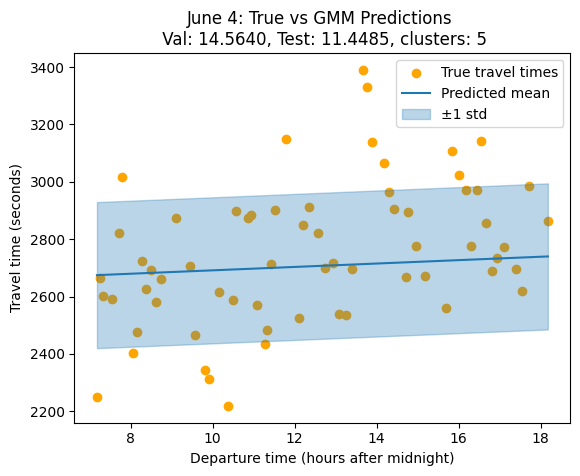

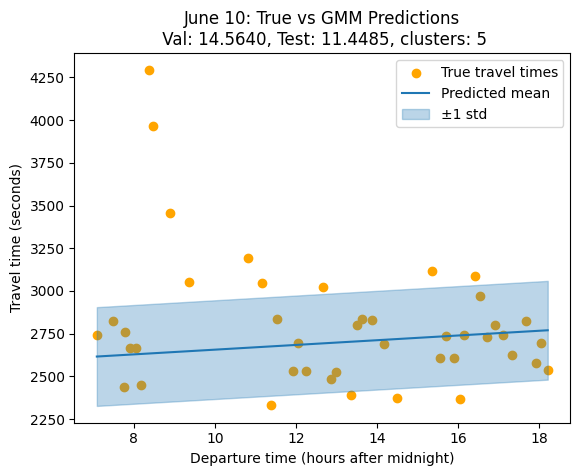

In [ ]:
y_pred, y_std = gmm_predict(best_gmm, X_test_full, y_scaler)
test_dates = pd.read_csv('traffic_data/june_data.csv')[['service_date']]
test_dates['service_date'] = pd.to_datetime(test_dates['service_date'])
y_true = y_scaler.inverse_transform(y_test.reshape(-1,1)).ravel()

plot_df = pd.DataFrame({
    'service_date': test_dates['service_date'].values,
    'from_stop_departure_sec': test_df['from_stop_departure_sec'].values,
    'y_true': y_true,
    'y_pred': y_pred,
    'y_std': y_std
})
plot_single_day(plot_df, pd.Timestamp('2024-06-04'), f'June 4: True vs GMM Predictions \n Val: {cond_ll_train.mean():.4f}, Test: {cond_ll_test.mean():.4f}, clusters: 5', x_scaler)
plot_single_day(plot_df, pd.Timestamp('2024-06-10'), f'June 10: True vs GMM Predictions\n Val: {cond_ll_train.mean():.4f}, Test: {cond_ll_test.mean():.4f}, clusters: 5', x_scaler)

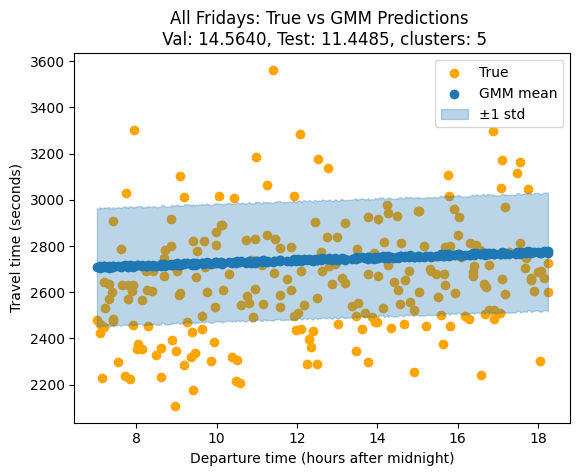

In [ ]:
std_scale = 1
fridays = plot_df[plot_df['service_date'].dt.dayofweek == 4] \
    .sort_values('from_stop_departure_sec')

dep_time_unscaled = ((fridays['from_stop_departure_sec'] * x_scaler.scale_[0]+ x_scaler.mean_[0]) /3600.0)

plt.figure()
plt.scatter(dep_time_unscaled, fridays['y_true'], label='True', color='orange')
plt.scatter(dep_time_unscaled, fridays['y_pred'], label='GMM mean', color='tab:blue')
plt.fill_between(
    dep_time_unscaled,
    fridays['y_pred'] - (std_scale * fridays['y_std']),
    fridays['y_pred'] + (std_scale * fridays['y_std']),
    alpha=0.3,
    label=f'±{std_scale} std',
    color='tab:blue')
plt.xlabel('Departure time (hours after midnight)')
plt.ylabel('Travel time (seconds)')
plt.title(f'All Fridays: True vs GMM Predictions \n Val: {cond_ll_train.mean():.4f}, Test: {cond_ll_test.mean():.4f}, clusters: 5')
plt.legend()
plt.show()

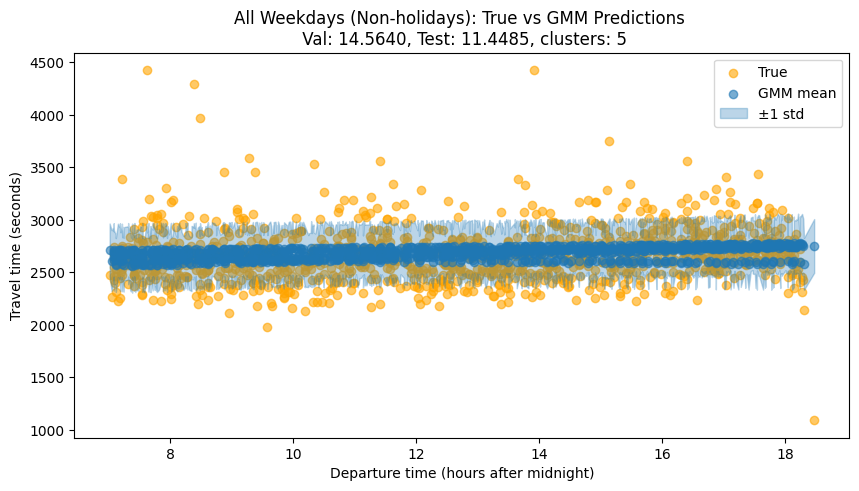

In [ ]:
weekdays_no_holiday = plot_df[
    (plot_df['service_date'].dt.dayofweek < 5) &  # Monday=0, ..., Friday=4
    (test_df['is_holiday'].values == 0)          # Exclude holidays
].sort_values('from_stop_departure_sec')

# Unscale departure times for plotting
dep_time_unscaled = ((weekdays_no_holiday['from_stop_departure_sec'] * x_scaler.scale_[0]
                     + x_scaler.mean_[0]) / 3600.0)

plt.figure(figsize=(10,5))
plt.scatter(dep_time_unscaled, weekdays_no_holiday['y_true'], label='True', color='orange', alpha=0.6)
plt.scatter(dep_time_unscaled, weekdays_no_holiday['y_pred'], label='GMM mean', color='tab:blue', alpha=0.6)
plt.fill_between(
    dep_time_unscaled,
    weekdays_no_holiday['y_pred'] - weekdays_no_holiday['y_std'],
    weekdays_no_holiday['y_pred'] + weekdays_no_holiday['y_std'],
    alpha=0.3,
    color='tab:blue',
    label='±1 std'
)
plt.xlabel('Departure time (hours after midnight)')
plt.ylabel('Travel time (seconds)')
plt.title(f'All Weekdays (Non-holidays): True vs GMM Predictions \n Val: {cond_ll_train.mean():.4f}, Test: {cond_ll_test.mean():.4f}, clusters: 5')
plt.legend()
plt.show()
